# 신경만 기반 방법론 활용 (DragonNet)

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1


In [3]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from xgboost import XGBRegressor

np.random.seed(42)
tf.random.set_seed(42)

## 1. IHDP 데이터 로드

- 데이터: ihdp_npci_1..9.csv(총 9개)에서 읽은 후 결합

- 원본 크기: (6723, 30) — 컬럼은 treatment, y_factual, y_cfactual, mu0, mu1 + 25개 피처

- 복제: 딥러닝 안정화를 위해 50배 복제 → (336,150, 31)

- 복제 전 행번호를 orig_row로 저장해, 복제 후에도 원본 행을 추적할 수 있게 함(후반부 불일치 분석에 사용)

In [4]:
df_raw = pd.DataFrame()
for i in range(1, 10):
    url = f"https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{i}.csv"
    data = pd.read_csv(url, header=None)
    df_raw = pd.concat([data, df_raw], ignore_index=True)

cols = ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df_raw.columns = cols
print("원본 데이터셋 크기:", df_raw.shape)

# 이진/연속 피처 순서 재배열
binfeats  = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats

# 원본 행 번호 보존
df_raw = df_raw.reset_index().rename(columns={"index":"orig_row"})

# 50배 복제
replications = 50
df = pd.concat([df_raw]*replications, ignore_index=True)
print("복제 후 데이터셋 크기:", df.shape)
df

원본 데이터셋 크기: (6723, 30)
복제 후 데이터셋 크기: (336150, 31)


,orig_row,treatment,y_factual,y_cfactual,mu0,mu1,0,1,2,3,...,15,16,17,18,19,20,21,22,23,24
0,0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,...,1,1,1,1,0,0,0,0,0,0
1,1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,...,1,1,1,1,0,0,0,0,0,0
2,2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,...,1,0,1,1,0,0,0,0,0,0
3,3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,...,1,0,1,1,0,0,0,0,0,0
4,4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336145,6718,0,4.091946,6.061976,3.986826,7.053195,-0.007654,-0.202946,-0.360898,0.161703,...,1,0,1,0,0,0,0,0,0,0
336146,6719,1,5.501677,4.237157,4.111877,7.084080,0.727295,-0.202946,-0.733261,-0.879606,...,1,1,1,0,0,0,0,0,0,0
336147,6720,0,1.842583,4.949537,2.346736,6.523225,1.181234,0.196818,-1.477987,0.161703,...,1,1,1,0,0,0,0,0,0,0
336148,6721,0,3.076368,7.554212,2.114661,6.419095,-0.288664,-0.202946,-1.477987,-0.879606,...,1,1,1,0,0,0,0,0,0,0


In [5]:
pd.Series(df['treatment']).value_counts(normalize=True)

,proportion
treatment,
0,0.813922
1,0.186078


## 2. 전처리

- 피처 재배열(perm): 이진 피처(19개) 먼저, 연속 피처 다음으로 정렬

- 표준화: StandardScaler로 모든 피처 z-스케일 -> 경사 스케일 정규화(학습 안정성/수렴속도)

- 데이터 분할: (50배 복제 기준) 70:30 train/test 분할. mu0, mu1, true_ite(= mu1-mu0)와 orig_row도 함께 분할해 이후 분석에 활용

In [6]:
X_df = df[perm]
X = X_df.values.astype(np.float32)
T = df["treatment"].values.astype(np.float32)
y_f = df["y_factual"].values.astype(np.float32)
mu0 = df["mu0"].values.astype(np.float32)
mu1 = df["mu1"].values.astype(np.float32)
true_ite = (mu1 - mu0).astype(np.float32)
orig_row_all = df["orig_row"].values.astype(np.int64)

# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

print("Feature X 크기:", X.shape)
print("처치 변수 T 크기:", T.shape)
print("실제 결과 y_factual 크기:", y_f.shape)
print("반사실 결과 y_cfactual 크기:", df["y_cfactual"].shape)

# train/test 분할 (원본 행 번호 포함)
X_tr, X_te, T_tr, T_te, y_tr, y_te, mu0_tr, mu0_te, mu1_tr, mu1_te, ite_tr, ite_te, orig_tr, orig_te = train_test_split(
    X, T, y_f, mu0, mu1, true_ite, orig_row_all, test_size=0.3, random_state=42
)

Feature X 크기: (336150, 25)
처치 변수 T 크기: (336150,)
실제 결과 y_factual 크기: (336150,)
반사실 결과 y_cfactual 크기: (336150,)


## 3. DragonNet 모델 (구성 & 학습)

- 구조 요약
  - 공유 인코더(2×Dense 256 + Dropout 0.1) →
    - 처치 헤드 t_out(sigmoid)
    - 결과 헤드 y0_out, y1_out(각각 독립 MLP 끝단)
    - 보조 ITE 헤드 ite_out = y1_out - y0_out(Targeted regularization용)

- 손실
  - t_out: Binary Cross Entropy(가중치 0.5)
  - y0_out, y1_out: Huber(δ=2.5)(각 1.0)
  - ite_out: MSE(가중치 0.03, 약하게)
  - 결과 헤드는 마스킹 학습(y0는 T=0 샘플만, y1은 T=1 샘플만 사용).

- 학습 하이퍼파라미터
  - Adam(lr=1e-3) + clipnorm=1.0: 빠른 수렴 + 기울기 폭주 방지
  - Dropout 0.1 + L2(1e-4): 표준적 정규화로 과적합 완화
  - Epochs=50, batch_size=2048: 큰 배치로 표현의 통계 안정 확보
  - EarlyStopping(patience=4): 과적합 구간 진입 전에 정지
  - ReduceLROnPlateau(factor=0.5, min_lr=1e-5): 검증 손실이 정체되면 학습률 반감 → 미세 조정 단계로 진입

In [8]:
def build_dragonnet_tarreg(input_dim, hidden=256, act="relu", l2=1e-4, drop=0.10):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(hidden, activation=act, kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(hidden, activation=act, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(drop)(x)

    # heads
    t_out = layers.Dense(1, activation="sigmoid", name="t_out")(x)
    y0_h = layers.Dense(hidden, activation=act, kernel_regularizer=regularizers.l2(l2))(x)
    y1_h = layers.Dense(hidden, activation=act, kernel_regularizer=regularizers.l2(l2))(x)
    y0_out = layers.Dense(1, name="y0_out")(y0_h)
    y1_out = layers.Dense(1, name="y1_out")(y1_h)
    ite_out = layers.Subtract(name="ite_out")([y1_out, y0_out])  # y1 - y0

    return models.Model(inputs=inp, outputs=[t_out, y0_out, y1_out, ite_out])

tarreg_weight = 0.03
dragonnet = build_dragonnet_tarreg(X_tr.shape[1], hidden=256, drop=0.10, l2=1e-4)

opt = optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
huber = tf.keras.losses.Huber(delta=2.5)

dragonnet.compile(
    optimizer=opt,
    loss={"t_out":"binary_crossentropy", "y0_out":huber, "y1_out":huber, "ite_out":"mse"},
    loss_weights={"t_out":0.5, "y0_out":1.0, "y1_out":1.0, "ite_out":tarreg_weight}
)

# 마스킹 가중치
w_t   = np.ones_like(T_tr, dtype=np.float32).ravel()
w_y0  = (1.0 - T_tr).astype(np.float32).ravel()
w_y1  = T_tr.astype(np.float32).ravel()
w_ite = np.ones_like(T_tr, dtype=np.float32).ravel()

T_tr_col   = T_tr.reshape(-1,1).astype(np.float32)
y_tr_col   = y_tr.reshape(-1,1).astype(np.float32)
ite_tr_col = ite_tr.reshape(-1,1).astype(np.float32)

cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
]

print("\n[학습 시작: epochs=30, batch_size=2048, 마스킹+Huber+TargetedReg]")
history = dragonnet.fit(
    X_tr,
    [T_tr_col, y_tr_col, y_tr_col, ite_tr_col],
    sample_weight=[w_t, w_y0, w_y1, w_ite],
    epochs=50,
    batch_size=2048,
    validation_split=0.1,
    callbacks=cbs,
    verbose=1
)


[학습 시작: epochs=30, batch_size=2048, 마스킹+Huber+TargetedReg]
Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - ite_out_loss: 92.0767 - loss: 16.6820 - t_out_loss: 0.5045 - y0_out_loss: 10.3611 - y1_out_loss: 3.2247 - val_ite_out_loss: 86.4651 - val_loss: 15.3074 - val_t_out_loss: 0.3977 - val_y0_out_loss: 9.8757 - val_y1_out_loss: 2.5543 - learning_rate: 0.0010
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - ite_out_loss: 79.6040 - loss: 14.8831 - t_out_loss: 0.3844 - y0_out_loss: 9.6665 - y1_out_loss: 2.5627 - val_ite_out_loss: 85.5048 - val_loss: 15.2373 - val_t_out_loss: 0.3413 - val_y0_out_loss: 9.8764 - val_y1_out_loss: 2.5473 - learning_rate: 0.0010
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - ite_out_loss: 78.8377 - loss: 14.8173 - t_out_loss: 0.3299 - y0_out_loss: 9.6610 - y1_out_loss: 2.5590 - val_ite_out_loss: 84.7879 - val_loss: 15.1652 - val_t_out_loss: 0.2733 - val_y0_out_loss: 9.8682 - val_y1_out_loss: 2.5429 - learning_rate: 0.0010
Epoch 4/50
104/10

## 4. DragonNet 예측 & ITE 산출

- 테스트셋에서 y0_hat, y1_hat을 예측 후 **winsorization(0.5~99.5 분위수 클립)**으로 폭주 억제
  - 극단적 외삽을 깎아 ITE 분포의 안정성을 높이기 위해
- 개별 ITE: ITE_DN = y1_hat - y0_hat

In [9]:
t_hat_te, y0_hat_te, y1_hat_te, _ = dragonnet.predict(X_te, verbose=0)
y0_hat_te = y0_hat_te.ravel()
y1_hat_te = y1_hat_te.ravel()

# winsorization 범위 (학습 y 분포 기준)
lo, hi = np.percentile(y_tr, [0.5, 99.5])
y0_hat_te = np.clip(y0_hat_te, lo, hi)
y1_hat_te = np.clip(y1_hat_te, lo, hi)

ite_dn_te = (y1_hat_te - y0_hat_te).astype(np.float32)  # DragonNet ITE

## 5. 메타러너 학습 & 테스트셋 ITE 비교

- S/T/X/R-learner: XGBRegressor 기반으로 같은 학습셋에서 학습, 테스트셋에서 ITE 예측

In [10]:
def _to1d(a):
    return np.nan_to_num(np.array(a).reshape(-1), nan=0.0, posinf=0.0, neginf=0.0)

s_learner = BaseSRegressor(learner=XGBRegressor())
t_learner = BaseTRegressor(learner=XGBRegressor())
x_learner = BaseXRegressor(learner=XGBRegressor())
r_learner = BaseRRegressor(learner=XGBRegressor())

s_learner.fit(X_tr, T_tr, y_tr)
t_learner.fit(X_tr, T_tr, y_tr)
x_learner.fit(X_tr, T_tr, y_tr)
r_learner.fit(X_tr, T_tr, y_tr)

ite_s_te = _to1d(s_learner.predict(X_te))
ite_t_te = _to1d(t_learner.predict(X_te))
ite_x_te = _to1d(x_learner.predict(X_te))
ite_r_te = _to1d(r_learner.predict(X_te))
ite_te    = _to1d(ite_te)  # ground-truth ITE

## 6. 성능지표(PEHE) & AUUC 커브

- RMSE(PEHE) 비교 + Uplift Gain Curve & AUUC 시각화
  - PEHE(RMSE of ITE) — ↓가 좋음
  - AUUC — ↑가 좋음 (랜덤 대비 uplift 품질)


===== 성능 비교 (PEHE: ITE RMSE) =====
DragonNet: 9.022446932236262
S-learner: 9.05399580922796
T-learner: 9.037864411758836
X-learner: 9.151469499695756
R-learner: 10.730674088536826


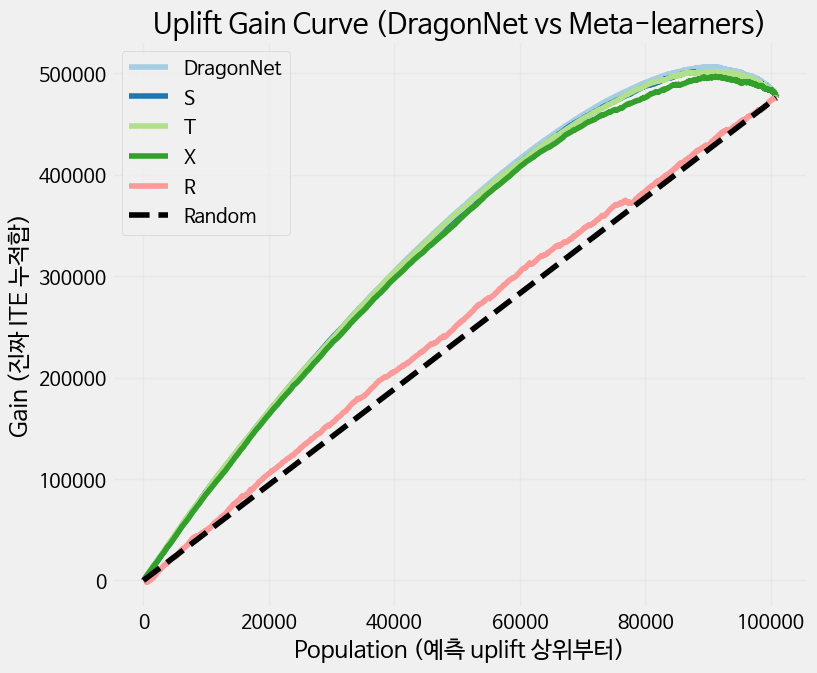


===== AUUC (면적, 클수록 좋음) =====
DragonNet: 33251484407.15
S: 33028606265.16
T: 33082158606.26
X: 32510503696.97
R: 25091532765.60
Random: 23990127135.88


In [11]:
rmse = lambda y, yhat: mean_squared_error(y, yhat)**0.5

print("\n===== 성능 비교 (PEHE: ITE RMSE) =====")
print("DragonNet:", rmse(ite_te, ite_dn_te))
print("S-learner:", rmse(ite_te, ite_s_te))
print("T-learner:", rmse(ite_te, ite_t_te))
print("X-learner:", rmse(ite_te, ite_x_te))
print("R-learner:", rmse(ite_te, ite_r_te))

def gain_curve(y_true_ite, y_pred_ite):
    order = np.argsort(-y_pred_ite)
    y_sorted = y_true_ite[order]
    pop = np.arange(1, len(y_sorted)+1)
    gain = np.cumsum(y_sorted)
    return pop, gain

curves = {
    "DragonNet": gain_curve(ite_te, ite_dn_te),
    "S": gain_curve(ite_te, ite_s_te),
    "T": gain_curve(ite_te, ite_t_te),
    "X": gain_curve(ite_te, ite_x_te),
    "R": gain_curve(ite_te, ite_r_te),
}
pop = np.arange(1, len(ite_te)+1)
baseline = np.mean(ite_te) * pop

plt.figure(figsize=(8,7))
for name,(px,gy) in curves.items():
    plt.plot(px, gy, label=name)
plt.plot(pop, baseline, "k--", label="Random")
plt.xlabel("Population (예측 uplift 상위부터)")
plt.ylabel("Gain (진짜 ITE 누적합)")
plt.title("Uplift Gain Curve (DragonNet vs Meta-learners)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

def auuc(px, gy):
    try:
        return np.trapezoid(gy, px)   # numpy>=2.0
    except AttributeError:
        return np.trapz(gy, px)       # numpy<2.0

print("\n===== AUUC (면적, 클수록 좋음) =====")
for name,(px,gy) in curves.items():
    print(f"{name}: {auuc(px,gy):.2f}")
print(f"Random: {auuc(pop, baseline):.2f}")

- 해석:
  - DragonNet·T·S가 사실상 근소한 차이로 비슷하고, X는 약간 뒤처짐, R은 랜덤과 유사
  - 모두 랜덤보다 우수. DragonNet이 가장 높은 AUUC, T/S가 근소한 차이로 뒤따름. (그래프에서도 상위구간에서 DragonNet이 살짝 우세)

## 7. 불일치가 큰 샘플 확인

- DragonNet vs T-learner


===== T-learner vs DragonNet: 불일치 최대 샘플 (원본 train 기준) =====
원본 데이터프레임 행 번호(global): 6575
원본 피처값(비표준화): [ 1.          0.          1.          0.          0.          0.
  0.          2.          1.          1.          1.          1.
  0.          0.          0.          0.          0.          0.
  1.          1.09476911  0.99634625 -1.47798693 -0.87960599  0.74618926
  2.2889095 ]
treatment / y_factual: 0.0 6.20815481332702
정답 μ0 / μ1: 6.53781624742568 7.54780326195372
정답 ITE(mu1-mu0): 1.0099873542785645
T-learner ITE: 12.535134315490723
DragonNet ITE: -7.461938858032227
절대 차이 |T - DN|: 19.997074127197266


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


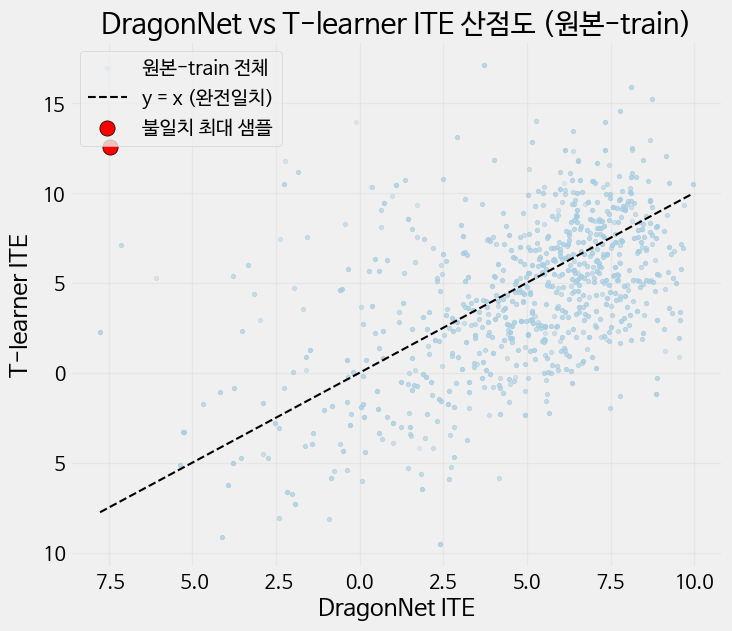

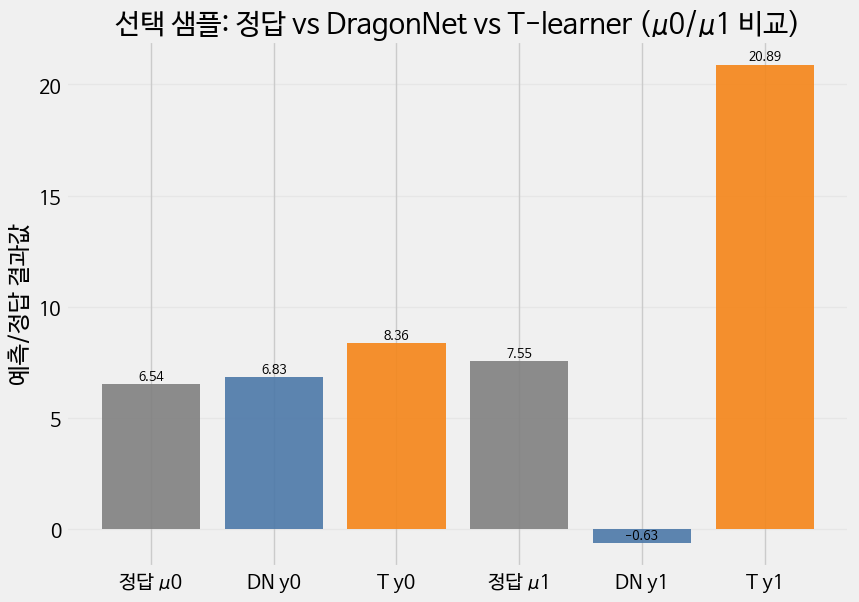

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


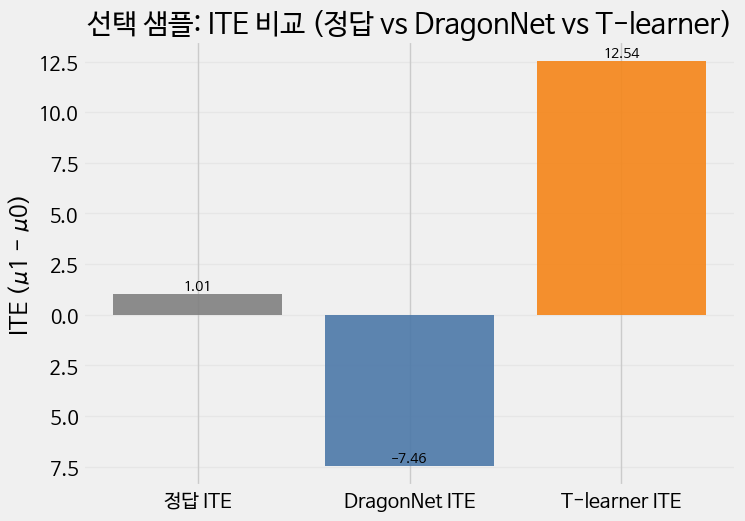

In [13]:
# 1) 원본(비복제) 데이터 준비 (비표준화 X -> 학습과 동일 스케일로 표준화)
X_raw_all    = df_raw[perm].values.astype(np.float32)
T_raw_all    = df_raw["treatment"].values.astype(np.float32)
y_raw_all    = df_raw["y_factual"].values.astype(np.float32)
mu0_raw_all  = df_raw["mu0"].values.astype(np.float32)
mu1_raw_all  = df_raw["mu1"].values.astype(np.float32)
true_ite_raw = (mu1_raw_all - mu0_raw_all).astype(np.float32)

X_raw_all_std = scaler.transform(X_raw_all).astype(np.float32)

# 2) 원본 데이터 70/30 분할
idx_train_raw, idx_val_raw = train_test_split(
    np.arange(len(X_raw_all_std)), test_size=0.3, random_state=42
)
X_train_raw   = X_raw_all_std[idx_train_raw]
T_train_raw   = T_raw_all[idx_train_raw]
y_train_raw   = y_raw_all[idx_train_raw]
mu0_train_raw = mu0_raw_all[idx_train_raw]
mu1_train_raw = mu1_raw_all[idx_train_raw]
tau_train_raw = true_ite_raw[idx_train_raw]

# 3) T-learner를 원본-train에 학습
t0_raw = XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42)
t1_raw = XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42)

mask0 = (T_train_raw == 0)
mask1 = (T_train_raw == 1)
t0_raw.fit(X_train_raw[mask0], y_train_raw[mask0])
t1_raw.fit(X_train_raw[mask1], y_train_raw[mask1])

# 4) 원본-train에서 T-learner 예측 (y0,y1, ITE)
y0_t_raw_tr = t0_raw.predict(X_train_raw).astype(np.float32)
y1_t_raw_tr = t1_raw.predict(X_train_raw).astype(np.float32)
# 폭주 방지: DragonNet과 동일 분위수로 winsorization
y0_t_raw_tr = np.clip(y0_t_raw_tr, lo, hi)
y1_t_raw_tr = np.clip(y1_t_raw_tr, lo, hi)
t_ite_train = (y1_t_raw_tr - y0_t_raw_tr).astype(np.float32)

# 5) 원본-train에서 DragonNet 예측 (y0,y1, ITE)
t_hat_raw_tr, y0_dn_raw_tr, y1_dn_raw_tr, _ = dragonnet.predict(X_train_raw, verbose=0)
y0_dn_raw_tr = np.clip(y0_dn_raw_tr.ravel(), lo, hi)
y1_dn_raw_tr = np.clip(y1_dn_raw_tr.ravel(), lo, hi)
dn_ite_train = (y1_dn_raw_tr - y0_dn_raw_tr).astype(np.float32)

# 6) 불일치 최대 샘플(절대 차이 기준) 선택
diff_abs = np.abs(t_ite_train - dn_ite_train)
pick_idx = int(np.argmax(diff_abs))           # 원본-train 내부 인덱스
global_row = int(idx_train_raw[pick_idx])     # df_raw 전체에서의 행 번호

# 7) 텍스트 요약 출력
print("\n===== T-learner vs DragonNet: 불일치 최대 샘플 (원본 train 기준) =====")
print("원본 데이터프레임 행 번호(global):", global_row)
print("원본 피처값(비표준화):", df_raw[perm].iloc[global_row].values)
print("treatment / y_factual:", float(df_raw.loc[global_row, "treatment"]), float(df_raw.loc[global_row, "y_factual"]))
print("정답 μ0 / μ1:", float(df_raw.loc[global_row, "mu0"]), float(df_raw.loc[global_row, "mu1"]))
print("정답 ITE(mu1-mu0):", float(true_ite_raw[global_row]))
print("T-learner ITE:", float(t_ite_train[pick_idx]))
print("DragonNet ITE:", float(dn_ite_train[pick_idx]))
print("절대 차이 |T - DN|:", float(diff_abs[pick_idx]))

# 8) 시각화
# 8-1) (전체) 산점도: DragonNet ITE vs T-learner ITE (불일치 최대점 강조)
plt.figure(figsize=(7.5, 6.5))
plt.scatter(dn_ite_train, t_ite_train, s=10, alpha=0.15, label="원본-train 전체")
plt.plot([dn_ite_train.min(), dn_ite_train.max()],
         [dn_ite_train.min(), dn_ite_train.max()],
         "k--", lw=1.5, label="y = x (완전일치)")
plt.scatter([dn_ite_train[pick_idx]], [t_ite_train[pick_idx]],
            s=120, c="red", edgecolor="black", label="불일치 최대 샘플")
plt.xlabel("DragonNet ITE")
plt.ylabel("T-learner ITE")
plt.title("DragonNet vs T-learner ITE 산점도 (원본-train)")
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# 8-2) (선택 샘플) 결과 비교 막대: 정답(μ0,μ1) vs DragonNet(y0,y1) vs T-learner(y0,y1)
mu0_g = float(mu0_raw_all[global_row]); mu1_g = float(mu1_raw_all[global_row])
bars_left  = ["정답 μ0", "DN y0", "T y0"]
vals_left  = [mu0_g, float(y0_dn_raw_tr[pick_idx]), float(y0_t_raw_tr[pick_idx])]
bars_right = ["정답 μ1", "DN y1", "T y1"]
vals_right = [mu1_g, float(y1_dn_raw_tr[pick_idx]), float(y1_t_raw_tr[pick_idx])]

plt.figure(figsize=(9, 6.5))
x = np.arange(len(bars_left) + len(bars_right))
heights = vals_left + vals_right
labels  = bars_left + bars_right
colors  = ["gray", "#4C78A8", "#F58518"] * 2

plt.bar(x, heights, color=colors, alpha=0.9)
plt.xticks(x, labels, rotation=0)
plt.ylabel("예측/정답 결과값")
plt.title("선택 샘플: 정답 vs DragonNet vs T-learner (μ0/μ1 비교)")
for xi, h in zip(x, heights):
    plt.text(xi, h, f"{h:.2f}", ha="center", va="bottom", fontsize=9)
plt.grid(axis="y", alpha=0.25)
plt.show()

# 8-3) (선택 샘플) ITE 비교 막대: 정답 vs DragonNet vs T-learner
ite_true = float(true_ite_raw[global_row])
ite_dn   = float(dn_ite_train[pick_idx])
ite_t    = float(t_ite_train[pick_idx])

plt.figure(figsize=(7.5, 5.5))
labels = ["정답 ITE", "DragonNet ITE", "T-learner ITE"]
vals   = [ite_true, ite_dn, ite_t]
plt.bar(labels, vals, color=["gray", "#4C78A8", "#F58518"], alpha=0.9)
for xi, h in enumerate(vals):
    plt.text(xi, h, f"{h:.2f}", ha="center", va="bottom", fontsize=10)
plt.ylabel("ITE (μ1 - μ0)")
plt.title("선택 샘플: ITE 비교 (정답 vs DragonNet vs T-learner)")
plt.grid(axis="y", alpha=0.25)
plt.show()